# Adaptive Regime Strategy

## Config

In [74]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from abc import ABC, abstractmethod
import warnings
from datetime import datetime, timedelta

# Suppress warnings
warnings.filterwarnings('ignore')

## Feature Engineering

In [75]:
# ==========================================
# 1. FEATURE ENGINEERING (The Math Lab)
# ==========================================

class FeatureLab:
    """Shared mathematical engine for technical and statistical features."""
    
    @staticmethod
    def get_weights_frac_diff(d, size, threshold=1e-5):
        w = [1.0]
        for k in range(1, size):
            w_k = -w[-1] / k * (d - k + 1)
            w.append(w_k)
        w = np.array(w[::-1])
        w = w[np.abs(w) > threshold]
        return w

    @staticmethod
    def frac_diff_fixed(series, d, window=50):
        weights = FeatureLab.get_weights_frac_diff(d, window)
        res = series.rolling(window=len(weights)).apply(lambda x: np.dot(x, weights), raw=True)
        return res

    @staticmethod
    def yang_zhang_volatility(df, window=30):
        log_ho = (df['High'] / df['Open']).apply(np.log)
        log_lo = (df['Low'] / df['Open']).apply(np.log)
        log_co = (df['Close'] / df['Open']).apply(np.log)
        log_oc = (df['Open'] / df['Close'].shift(1)).apply(np.log)
        log_cc = (df['Close'] / df['Close'].shift(1)).apply(np.log)
        
        rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)
        close_vol = log_cc.rolling(window=window).var()
        open_vol = log_oc.rolling(window=window).var()
        window_rs = rs.rolling(window=window).mean()

        k = 0.34 / (1.34 + (window + 1) / (window - 1))
        return np.sqrt(open_vol + k * window_rs)

    @staticmethod
    def compute_rsi(series, window=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

## Utils

In [76]:
# ==========================================
# 2. BASE STRATEGY INFRASTRUCTURE
# ==========================================

class BaseStrategy(ABC):
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.results = None
        self.metrics = {}

    def fetch_data(self, warmup_years=2):
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d")
        warmup_start_dt = start_dt - timedelta(days=warmup_years*365)
        warmup_start_str = warmup_start_dt.strftime("%Y-%m-%d")
        
        try:
            self.data = yf.download(self.ticker, start=warmup_start_str, end=self.end_date, progress=False, auto_adjust=False)
            if isinstance(self.data.columns, pd.MultiIndex): 
                self.data.columns = self.data.columns.get_level_values(0)
            if 'Adj Close' not in self.data.columns: 
                self.data['Adj Close'] = self.data['Close']
            self.data['Returns'] = self.data['Adj Close'].pct_change()
            self.data.dropna(inplace=True)
        except Exception as e:
            print(f"Error fetching {self.ticker}: {e}")
            self.data = pd.DataFrame()

    @abstractmethod
    def generate_signals(self):
        pass

    def run_backtest(self, transaction_cost=0.0005, rebalance_threshold=0.1):
        if self.data is None or self.data.empty: return
        
        backtest_mask = self.data.index >= self.start_date
        df = self.data.loc[backtest_mask].copy()
        if df.empty: return

        # Hysteresis / Buffer Logic for Position Smoothing
        clean_positions = []
        current_pos = 0.0
        raw_signals = df['Signal'].values
        
        for target in raw_signals:
            if abs(target - current_pos) > rebalance_threshold:
                current_pos = target
            clean_positions.append(current_pos)
            
        df['Position'] = clean_positions
        df['Prev_Position'] = df['Position'].shift(1).fillna(0)
        df['Turnover'] = (df['Prev_Position'] - df['Position'].shift(2).fillna(0)).abs()
        df['Gross_Returns'] = df['Prev_Position'] * df['Returns']
        df['Net_Returns'] = df['Gross_Returns'] - (df['Turnover'] * transaction_cost)
        df['Net_Returns'].fillna(0, inplace=True)
        
        df['Cumulative_Strategy'] = (1 + df['Net_Returns']).cumprod()
        df['Cumulative_Market'] = (1 + df['Returns']).cumprod()
        
        roll_max = df['Cumulative_Strategy'].cummax()
        df['Drawdown'] = (df['Cumulative_Strategy'] / roll_max) - 1.0
        
        self.results = df
        
        # Performance Calculation
        total_ret = df['Cumulative_Strategy'].iloc[-1] - 1
        vol = df['Net_Returns'].std() * np.sqrt(252)
        sharpe = (df['Net_Returns'].mean() / df['Net_Returns'].std()) * np.sqrt(252) if vol > 0 else 0
        max_dd = df['Drawdown'].min()
        
        self.metrics = {
            'Total Return': total_ret,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_dd,
            'Final Value': df['Cumulative_Strategy'].iloc[-1]
        }
        return df


## v1

In [77]:
class StrategyV1_Baseline(BaseStrategy):
    """V1: Fixed FracDiff, Standard GMM, Simple Volatility Targeting."""
    def generate_signals(self):
        if self.data is None or self.data.empty: return
        df = self.data.copy()
        
        df['Volatility'] = FeatureLab.yang_zhang_volatility(df)
        df['FracDiff'] = FeatureLab.frac_diff_fixed(df['Adj Close'].apply(np.log), d=0.4, window=50)
        df['RSI'] = FeatureLab.compute_rsi(df['Adj Close'])
        df['Returns_Smoothed'] = df['Returns'].rolling(5).mean()
        df['Vol_Smoothed'] = df['Volatility'].rolling(5).mean()
        df.dropna(inplace=True)
        
        X = df[['Returns_Smoothed', 'Vol_Smoothed']].values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        gmm = GaussianMixture(n_components=3, random_state=42)
        df['Cluster'] = gmm.fit_predict(X_scaled)
        
        stats = df.groupby('Cluster')['Returns_Smoothed'].mean().sort_values().index
        mapping = {stats[0]: -1, stats[1]: 0, stats[2]: 1}
        df['Regime'] = df['Cluster'].map(mapping)
        
        df['Signal'] = 0
        df.loc[(df['Regime'] == 1) & (df['FracDiff'] > 0), 'Signal'] = 1
        df.loc[(df['Regime'] == 0) & (df['RSI'] < 40), 'Signal'] = 1
        
        target_vol = 0.15 / np.sqrt(252)
        df['Vol_Scaler'] = (target_vol / df['Volatility']).clip(upper=1.5)
        df['Signal'] = df['Signal'] * df['Vol_Scaler']
        self.data = df

## v2

In [78]:
class StrategyV2_Advanced(BaseStrategy):
    """V2: Rolling Window GMM, Asymmetric Leverage, Deep Value Overrides."""
    def generate_signals(self):
        if self.data is None or self.data.empty: return
        df = self.data.copy()
        
        df['Volatility'] = FeatureLab.yang_zhang_volatility(df)
        df['FracDiff'] = FeatureLab.frac_diff_fixed(df['Adj Close'].apply(np.log), d=0.4, window=50)
        df['RSI'] = FeatureLab.compute_rsi(df['Adj Close'])
        df['Returns_Smoothed'] = df['Returns'].rolling(5).mean()
        df['Vol_Smoothed'] = df['Volatility'].rolling(5).mean()
        df.dropna(inplace=True)
        
        df['Regime'] = 0
        window_size, step_size = 504, 126
        preds, indices = [], []
        
        if len(df) > window_size:
            for t in range(window_size, len(df), step_size):
                train = df.iloc[t-window_size:t]
                test = df.iloc[t:t+step_size]
                if test.empty: break
                
                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(train[['Returns_Smoothed', 'Vol_Smoothed']].values)
                X_test_s = scaler.transform(test[['Returns_Smoothed', 'Vol_Smoothed']].values)
                
                gmm = GaussianMixture(n_components=3, random_state=42).fit(X_train_s)
                train['Clust'] = gmm.predict(X_train_s)
                stats = train.groupby('Clust')['Returns_Smoothed'].mean().sort_values().index
                mapping = {stats[0]: -1, stats[1]: 0, stats[2]: 1}
                
                preds.extend([mapping[x] for x in gmm.predict(X_test_s)])
                indices.extend(test.index)
            
            df.loc[indices, 'Regime'] = pd.Series(preds, index=indices)
        
        df['Signal'] = 0
        df.loc[(df['Regime'] == 1) & (df['FracDiff'] > 0), 'Signal'] = 1
        df.loc[(df['Regime'] == 0) & (df['RSI'] < 45), 'Signal'] = 1
        df.loc[(df['Regime'] == -1) & (df['RSI'] < 30), 'Signal'] = 0.5
        
        strong_trend = (df['Regime'] == 0) & (df['FracDiff'] > 1e-4) & (df['RSI'] < 80)
        df.loc[strong_trend, 'Signal'] = 1
        
        target_vol = 0.15 / np.sqrt(252)
        df['Base_Scaler'] = target_vol / df['Volatility']
        df['Final_Scaler'] = df['Base_Scaler'].clip(upper=1.0)
        df.loc[df['Regime'] >= 0, 'Final_Scaler'] = df.loc[df['Regime'] >= 0, 'Base_Scaler'].clip(upper=2.0)
        
        df['Signal'] = df['Signal'] * df['Final_Scaler']
        self.data = df

## v3

In [79]:
class StrategyV3_Macro(BaseStrategy):
    """V3: Institutional Standard with Macro (SPY) Filter."""
    def __init__(self, ticker, start_date, end_date):
        super().__init__(ticker, start_date, end_date)
        self.spy_data = None

    def fetch_data(self, warmup_years=2):
        super().fetch_data(warmup_years)
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d") - timedelta(days=warmup_years*365)
        try:
            spy = yf.download("SPY", start=start_dt.strftime("%Y-%m-%d"), end=self.end_date, progress=False, auto_adjust=False)
            if isinstance(spy.columns, pd.MultiIndex): spy.columns = spy.columns.get_level_values(0)
            self.spy_data = spy[['Adj Close']].rename(columns={'Adj Close': 'SPY_Price'})
        except Exception as e:
            print(f"Error fetching SPY: {e}")

    def generate_signals(self):
        if self.data is None or self.data.empty: return
        df = self.data.copy()
        
        if self.spy_data is not None:
            df = df.join(self.spy_data, how='left')
            df['SPY_MA200'] = df['SPY_Price'].rolling(window=200).mean()
            df['Macro_Bull'] = df['SPY_Price'] > df['SPY_MA200']
        else:
            df['Macro_Bull'] = True
            
        df['Volatility'] = FeatureLab.yang_zhang_volatility(df)
        df['FracDiff'] = FeatureLab.frac_diff_fixed(df['Adj Close'].apply(np.log), d=0.4, window=50)
        df['RSI'] = FeatureLab.compute_rsi(df['Adj Close'])
        df['Returns_Smoothed'] = df['Returns'].rolling(5).mean()
        df['Vol_Smoothed'] = df['Volatility'].rolling(5).mean()
        df.dropna(inplace=True)
        
        X_scaled = StandardScaler().fit_transform(df[['Returns_Smoothed', 'Vol_Smoothed']].values)
        gmm = GaussianMixture(n_components=3, random_state=42)
        df['Cluster'] = gmm.fit_predict(X_scaled)
        stats = df.groupby('Cluster')['Returns_Smoothed'].mean().sort_values().index
        df['Regime'] = df['Cluster'].map({stats[0]: -1, stats[1]: 0, stats[2]: 1})
        
        df['Signal'] = 0
        df.loc[(df['Regime'] == 1) & (df['FracDiff'] > 0), 'Signal'] = 1
        df.loc[(df['Regime'] == 0) & (df['RSI'] < 45), 'Signal'] = 1
        
        strong_trend = (df['Regime'] == 0) & (df['FracDiff'] > 1e-4) & (df['RSI'] < 80)
        df.loc[strong_trend, 'Signal'] = 1
        
        # Macro Filter Override
        df.loc[df['Macro_Bull'] == False, 'Signal'] = 0
        
        target_vol = 0.15 / np.sqrt(252)
        df['Base_Scaler'] = target_vol / df['Volatility']
        df['Final_Scaler'] = 1.0
        bull_market_bull_stock = (df['Macro_Bull'] == True) & (df['Regime'] == 1)
        df.loc[bull_market_bull_stock, 'Final_Scaler'] = df.loc[bull_market_bull_stock, 'Base_Scaler'].clip(upper=2.0)
        
        df['Signal'] = df['Signal'] * df['Final_Scaler']
        self.data = df

## v4

In [80]:
# ==========================================
# REVISED FEATURE LAB (MIT Standard)
# ==========================================
from statsmodels.tsa.stattools import adfuller

class AdvancedFeatureLab(FeatureLab):
    
    @staticmethod
    def get_optimal_d(series, max_d=1.0, step=0.05, p_val_thresh=0.05):
        """
        Iteratively finds the minimum 'd' that makes the series stationary (ADF p < 0.05).
        As per Lopez de Prado (2018).
        """
        # Iterate d from 0 to 1
        for d in np.arange(0, max_d, step):
            # Apply FracDiff (using your existing logic for weights)
            diff_series = FeatureLab.frac_diff_fixed(series, d=d)
            diff_series = diff_series.dropna()
            
            # Check for Stationarity via ADF
            # We need enough data points for ADF
            if len(diff_series) > 100:
                adf_res = adfuller(diff_series, maxlag=1, regression='c', autolag=None)
                p_val = adf_res[1]
                
                if p_val < p_val_thresh:
                    return d, diff_series
                    
        return 1.0, series.diff() # Fallback to integer differentiation

    @staticmethod
    def triple_barrier_labels(prices, vol, pt=1.0, sl=1.0, barrier_window=10):
        """
        Implements the Triple Barrier Method for Labeling.
        Returns: 1 (Profit), -1 (Loss), 0 (Time/Neutral)
        """
        labels = []
        for t in range(len(prices) - barrier_window):
            current_p = prices.iloc[t]
            current_vol = vol.iloc[t]
            
            # Dynamic Barriers based on Volatility
            upper = current_p * (1 + pt * current_vol)
            lower = current_p * (1 - sl * current_vol)
            
            # Look forward window
            path = prices.iloc[t+1 : t+1+barrier_window]
            
            # Check barriers
            hit_upper = (path >= upper).any()
            hit_lower = (path <= lower).any()
            
            if hit_upper and not hit_lower:
                labels.append(1)
            elif hit_lower and not hit_upper:
                labels.append(-1)
            elif hit_upper and hit_lower:
                # Hit both? Whichever happened first.
                first_upper = (path >= upper).idxmax()
                first_lower = (path <= lower).idxmax()
                labels.append(1 if first_upper < first_lower else -1)
            else:
                labels.append(0) # Vertical Barrier (Time)
                
        return np.array(labels)

In [81]:
# ==========================================
# 4. INSTITUTIONAL STRATEGY (V4)
# ==========================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score

class AdvancedFeatureLab(FeatureLab):
    """
    Upgraded Math Lab with ADF Optimization and Triple Barrier Labeling.
    """
    @staticmethod
    def get_optimal_d(series, max_d=1.0, step=0.05, p_val_thresh=0.05):
        """
        Iteratively finds the minimum 'd' that makes the series stationary.
        Ref: Lopez de Prado (2018).
        """
        # Iterate d from 0 to 1
        best_d = 1.0
        best_series = series.diff().dropna() # Default to d=1
        
        for d in np.arange(0, max_d, step):
            if d < 0.05: continue # Skip trivial d
            
            # Apply FracDiff (using existing weights logic)
            # Note: In production, cache weights to speed up
            try:
                diff_series = FeatureLab.frac_diff_fixed(series, d=d, window=50)
                diff_series = diff_series.dropna()
                
                # Check for Stationarity via ADF
                if len(diff_series) > 100:
                    adf_res = adfuller(diff_series, maxlag=1, regression='c', autolag=None)
                    p_val = adf_res[1]
                    
                    if p_val < p_val_thresh:
                        return d, diff_series
            except:
                continue
                    
        return best_d, best_series

    @staticmethod
    def triple_barrier_labels(prices, vol, pt=1.0, sl=1.0, barrier_window=10):
        """
        Creates the 'True' Target for the ML Model.
        1 = Profit Target hit first
        0 = Stop Loss hit first OR Time Limit reached (Neutral)
        """
        labels = pd.Series(0, index=prices.index)
        
        # Vectorized approach is harder for barriers, using fast loop
        # We look ahead 'barrier_window' steps
        for i in range(len(prices) - barrier_window):
            t = prices.index[i]
            current_p = prices.iloc[i]
            current_vol = vol.iloc[i]
            
            # Dynamic Widths based on Volatility [cite: 215, 216]
            # If vol is high, barriers are wider.
            target_price = current_p * (1 + pt * current_vol)
            stop_price = current_p * (1 - sl * current_vol)
            
            future_window = prices.iloc[i+1 : i+1+barrier_window]
            
            # Did we hit the target?
            hit_target = future_window[future_window >= target_price]
            # Did we hit the stop?
            hit_stop = future_window[future_window <= stop_price]
            
            if not hit_target.empty and (hit_stop.empty or hit_target.index[0] < hit_stop.index[0]):
                labels.iloc[i] = 1 # Success
            elif not hit_stop.empty and (hit_target.empty or hit_stop.index[0] < hit_target.index[0]):
                labels.iloc[i] = -1 # Failure (mapped to 0 for binary classification later)
            # Else 0 (Time expiry)
            
        return labels

class StrategyV4_Meta(BaseStrategy):
    """
    V4: Meta-Labeling Strategy.
    1. Primary Signal: Regime-based (V3).
    2. Meta Model: Random Forest trained on Triple Barrier outcomes.
    """
    def generate_signals(self):
        if self.data is None or self.data.empty: return
        df = self.data.copy()
        
        # --- 1. Advanced Feature Engineering ---
        # Volatility
        df['Volatility'] = FeatureLab.yang_zhang_volatility(df)
        
        # Dynamic FracDiff [cite: 74]
        # We optimize d for the specific asset
        log_prices = df['Adj Close'].apply(np.log)
        best_d, frac_series = AdvancedFeatureLab.get_optimal_d(log_prices)
        df['FracDiff'] = frac_series
        print(f"[{self.ticker}] Optimal d: {best_d}")

        df['RSI'] = FeatureLab.compute_rsi(df['Adj Close'])
        df['Returns_Smoothed'] = df['Returns'].rolling(5).mean()
        df['Vol_Smoothed'] = df['Volatility'].rolling(5).mean()
        df.dropna(inplace=True)
        
        # --- 2. Primary Signal Generation (Regime Detection) ---
        # We reuse the GMM logic to create a 'Candidate' signal
        X_scaled = StandardScaler().fit_transform(df[['Returns_Smoothed', 'Vol_Smoothed']].values)
        gmm = GaussianMixture(n_components=3, random_state=42)
        df['Cluster'] = gmm.fit_predict(X_scaled)
        stats = df.groupby('Cluster')['Returns_Smoothed'].mean().sort_values().index
        df['Regime'] = df['Cluster'].map({stats[0]: -1, stats[1]: 0, stats[2]: 1})
        
        # Candidate Signal: Long only in Bull (1) or Oversold Range (0)
        df['Primary_Signal'] = 0
        df.loc[(df['Regime'] == 1) & (df['FracDiff'] > 0), 'Primary_Signal'] = 1
        df.loc[(df['Regime'] == 0) & (df['RSI'] < 45), 'Primary_Signal'] = 1
        
        # --- 3. Meta-Labeling (The ML Filter) ---
        # Generate Ground Truth: Did buying actually work? 
        # Profit Target = 1x Vol, Stop Loss = 1x Vol, Window = 10 days
        labels = AdvancedFeatureLab.triple_barrier_labels(
            df['Adj Close'], df['Volatility'], pt=1.0, sl=1.0, barrier_window=10
        )
        df['Target'] = labels
        # We only care about predicting "Success" (1). -1 and 0 are "Don't Trade".
        df['Meta_Target'] = (df['Target'] == 1).astype(int)
        
        # --- 4. Walk-Forward Training ---
        # We cannot train on the whole dataset (Look-ahead bias).
        # We train a model at time T using data 0...T-1
        
        clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42, class_weight='balanced')
        
        # Features for the Meta-Model
        # We want to know: "Given the Primary Signal says YES, should we trust it?"
        meta_features = ['Volatility', 'FracDiff', 'RSI', 'Returns_Smoothed', 'Regime']
        
        df['Meta_Prediction'] = 0.0
        
        # Rolling Window Training (Simple Walk-Forward)
        # Train on initial 2 years (approx 500 days), predict next month, roll.
        start_window = 500
        step_size = 20 # Re-train every month
        
        if len(df) > start_window:
            for t in range(start_window, len(df), step_size):
                train_idx = df.index[:t]
                test_idx = df.index[t:t+step_size]
                
                # Filter Training Data: We only learn from times the Primary Signal was ACTIVE (1) [cite: 231]
                # Because the Meta-Model answers: "If Primary=1, is it a True Positive?"
                X_train = df.loc[train_idx, meta_features]
                y_train = df.loc[train_idx, 'Meta_Target']
                
                # Only train on instances where Primary Signal was 1
                # (We don't care about correcting the model when it says 'wait')
                train_mask = df.loc[train_idx, 'Primary_Signal'] != 0
                if train_mask.sum() < 50: # Not enough data to learn yet
                    continue
                    
                X_train_filtered = X_train.loc[train_mask]
                y_train_filtered = y_train.loc[train_mask]
                
                try:
                    clf.fit(X_train_filtered, y_train_filtered)
                    
                    # Predict for the test window
                    X_test = df.loc[test_idx, meta_features]
                    # We want the probability of Class 1 (Success)
                    probs = clf.predict_proba(X_test)[:, 1]
                    df.loc[test_idx, 'Meta_Prediction'] = probs
                except:
                    pass # Keep prediction as 0 if fail

        # --- 5. Final Signal Composition ---
        # Logic: Primary Signal says GO AND Meta-Model is > 55% Confident [cite: 231]
        df['Final_Signal'] = 0
        confidence_threshold = 0.55
        
        valid_trade = (df['Primary_Signal'] == 1) & (df['Meta_Prediction'] > confidence_threshold)
        df.loc[valid_trade, 'Final_Signal'] = 1
        
        # Volatility Sizing (Kelly-like)
        # If confident, size by volatility [cite: 255]
        target_vol = 0.15 / np.sqrt(252)
        df['Vol_Scaler'] = (target_vol / df['Volatility']).clip(upper=1.5)
        
        # If Meta Model is VERY confident (>0.7), we can increase size
        df.loc[df['Meta_Prediction'] > 0.7, 'Vol_Scaler'] *= 1.2
        
        df['Signal'] = df['Final_Signal'] * df['Vol_Scaler']
        
        self.data = df

# Example usage within the existing benchmark framework
# s = StrategyV4_Meta("AAPL", "2020-01-01", "2024-12-30")

## Benchmark

TEST CASE            | TICKER | STRATEGY  | RETURN  | SHARPE | MAX DD  
--------------------------------------------------------------------------------
2020 Crash           | AAPL  | V1        | 45.8%   | 2.31  | -4.9%
                     |       | V2        | 45.8%   | 1.78  | -15.3%
                     |       | V3        | 52.7%   | 2.48  | -4.9%
[AAPL] Optimal d: 0.4
                     |       | V4        | 13.7%   | 1.14  | -4.9%
--------------------------------------------------------------------------------
2020 Crash           | GOOG  | V1        | -4.0%   | -0.09  | -19.0%
                     |       | V2        | 9.3%   | 0.52  | -19.8%
                     |       | V3        | 4.6%   | 0.33  | -14.7%
[GOOG] Optimal d: 0.25
                     |       | V4        | 2.1%   | 0.46  | -3.1%
--------------------------------------------------------------------------------
2020 Crash           | AMD   | V1        | -3.5%   | -0.12  | -18.5%
                     |       | V2

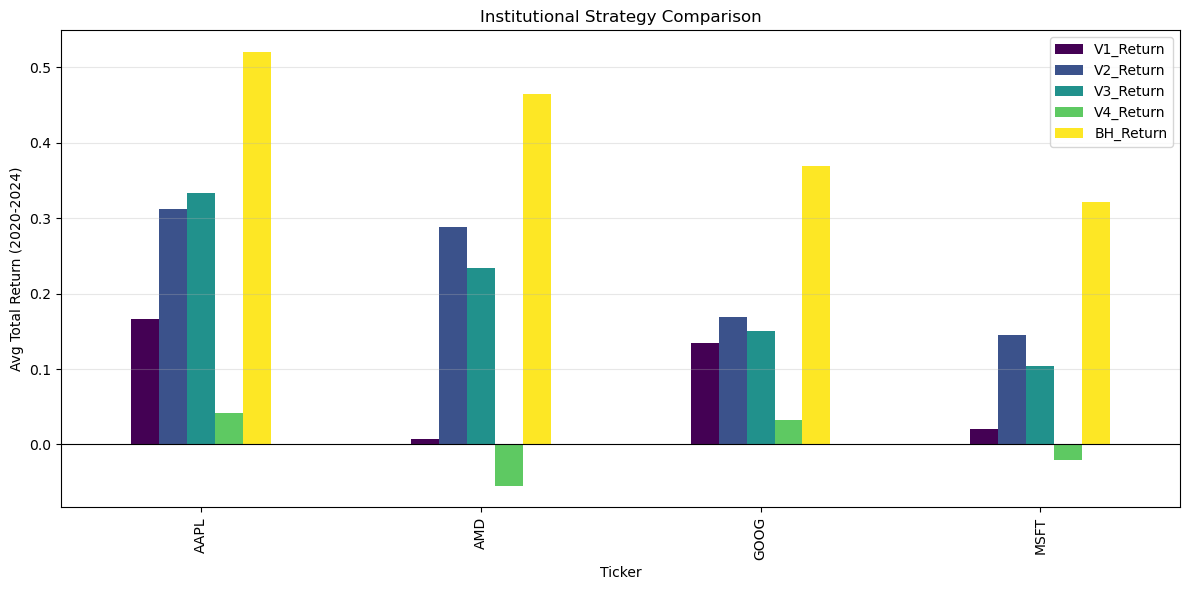

In [82]:
def run_benchmark():
    test_cases = [
        ("2020 Crash", "2020-01-01", "2020-12-31"),
        ("2022 Bear Market", "2022-01-01", "2022-12-31"),
        ("2023-24 Bull Run", "2023-01-01", "2024-12-30")
    ]
    tickers = ["AAPL", "GOOG", "AMD", "MSFT"]
    results_table = []

    print(f"{'TEST CASE':<20} | {'TICKER':<5} | {'STRATEGY':<9} | {'RETURN':<7} | {'SHARPE':<5} | {'MAX DD':<8}")
    print("-" * 80)

    for case_name, start, end in test_cases:
        for ticker in tickers:
            strats = {
                "V1": StrategyV1_Baseline(ticker, start, end),
                "V2": StrategyV2_Advanced(ticker, start, end),
                "V3": StrategyV3_Macro(ticker, start, end),
                "V4": StrategyV4_Meta(ticker, start, end),
            }
            
            row_res = {'Scenario': case_name, 'Ticker': ticker}
            
            for name, s in strats.items():
                s.fetch_data(warmup_years=2)
                s.generate_signals()
                s.run_backtest()
                
                if s.metrics:
                    print(f"{case_name if name=='V1' else '':<20} | {ticker if name=='V1' else '':<5} | {name:<9} | {s.metrics['Total Return']:.1%}   | {s.metrics['Sharpe Ratio']:.2f}  | {s.metrics['Max Drawdown']:.1%}")
                    row_res[f'{name}_Return'] = s.metrics['Total Return']
            
            if strats["V1"].results is not None:
                row_res['BH_Return'] = strats["V1"].results['Cumulative_Market'].iloc[-1] - 1
            
            results_table.append(row_res)
            print("-" * 80)

    # Visualization
    df_res = pd.DataFrame(results_table)
    summary = df_res.groupby('Ticker')[['V1_Return', 'V2_Return', 'V3_Return', 'V4_Return', 'BH_Return']].mean()
    summary.plot(kind='bar', figsize=(12, 6), colormap='viridis')
    plt.title("Institutional Strategy Comparison")
    plt.ylabel("Avg Total Return (2020-2024)")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_benchmark()